,UserId,Age,Sequence,Fastest,MostAccurate,Ranking,UsageFrequency
0,1,28,"[TuiJoystick, TouchJoystick, TuiCar, TouchGesture]","{'Track 1': TuiJoystick, 'Track 2': TuiCar, 'Track 3': TuiCar}","{'Track 1': TuiCar, 'Track 2': TuiJoystick, 'Track 3': TouchGesture}","{'Platz 1': TuiJoystick, 'Platz 2': TuiCar, 'Platz 3': TouchGesture, 'Platz 4': TouchJoystick}","{'Smartphone': 'tÃ¤glich', 'Tablet': 'regelmÃ¤ÃŸig', 'Multitouch-Tisch': 'regelmÃ¤ÃŸig', 'Tangibles': 'regelmÃ¤ÃŸig', 'Videospiele': 'regelmÃ¤ÃŸig'}"
1,2,35,"[TuiJoystick, TouchGesture, TouchJoystick, TuiCar]","{'Track 1': TuiJoystick, 'Track 2': TouchJoystick, 'Track 3': TuiCar}","{'Track 1': TuiJoystick, 'Track 2': TuiJoystick, 'Track 3': TuiCar}","{'Platz 1': TuiJoystick, 'Platz 2': TuiCar, 'Platz 3': TouchJoystick, 'Platz 4': TouchGesture}","{'Smartphone': 'tÃ¤glich', 'Tablet': 'tÃ¤glich', 'Multitouch-Tisch': 'schon einmal genutzt', 'Tangibles': 'schon einmal genutzt', 'Videospiele': 'regelmÃ¤ÃŸig'}"
2,3,36,"[TouchGesture, TouchJoystick, TuiJoystick, TuiCar]","{'Track 1': TuiJoystick, 'Track 2': TuiCar, 'Track 3': TuiCar}","{'Track 1': TuiCar, 'Track 2': TuiCar, 'Track 3': TuiCar}","{'Platz 1': TuiCar, 'Platz 2': TouchGesture, 'Platz 3': TuiJoystick, 'Platz 4': TouchJoystick}","{'Smartphone': 'tÃ¤glich', 'Tablet': 'regelmÃ¤ÃŸig', 'Multitouch-Tisch': 'schon einmal genutzt', 'Tangibles': 'noch nie', 'Videospiele': 'schon einmal genutzt'}"
3,4,35,"[TuiCar, TouchGesture, TuiJoystick, TouchJoystick]","{'Track 1': TuiCar, 'Track 2': TuiCar, 'Track 3': TuiCar}","{'Track 1': TuiCar, 'Track 2': TuiCar, 'Track 3': TuiCar}","{'Platz 1': TuiCar, 'Platz 2': TuiJoystick, 'Platz 3': TouchJoystick, 'Platz 4': TouchGesture}","{'Smartphone': 'tÃ¤glich', 'Tablet': 'regelmÃ¤ÃŸig', 'Multitouch-Tisch': 'schon einmal genutzt', 'Tangibles': 'noch nie', 'Videospiele': 'schon einmal genutzt'}"
4,5,29,"[TuiCar, TouchGesture, TouchJoystick, TuiJoystick]","{'Track 1': TouchJoystick, 'Track 2': TouchJoystick, 'Track 3': TouchJoystick}","{'Track 1': TuiCar, 'Track 2': TuiJoystick, 'Track 3': TuiJoystick}","{'Platz 1': TuiCar, 'Platz 2': TouchJoystick, 'Platz 3': TuiJoystick, 'Platz 4': TouchGesture}","{'Smartphone': 'tÃ¤glich', 'Tablet': 'hin und wieder', 'Multitouch-Tisch': 'regelmÃ¤ÃŸig', 'Tangibles': 'regelmÃ¤ÃŸig', 'Videospiele': 'hin und wieder'}"
5,6,36,"[TouchGesture, TouchJoystick, TuiJoystick, TuiCar]","{'Track 1': TuiJoystick, 'Track 2': TuiJoystick, 'Track 3': TuiCar}","{'Track 1': TuiJoystick, 'Track 2': TuiCar, 'Track 3': TuiJoystick}","{'Platz 1': TuiJoystick, 'Platz 2': TuiCar, 'Platz 3': TouchGesture, 'Platz 4': TouchJoystick}","{'Smartphone': 'tÃ¤glich', 'Tablet': 'regelmÃ¤ÃŸig', 'Multitouch-Tisch': 'noch nie', 'Tangibles': 'noch nie', 'Videospiele': 'schon einmal genutzt'}"
6,7,37,"[TouchJoystick, TouchGesture, TuiJoystick, TuiCar]","{'Track 1': TuiJoystick, 'Track 2': TuiJoystick, 'Track 3': TuiCar}","{'Track 1': TouchGesture, 'Track 2': TouchGesture, 'Track 3': TuiCar}","{'Platz 1': TouchGesture, 'Platz 2': TuiCar, 'Platz 3': TuiJoystick, 'Platz 4': TouchJoystick}","{'Smartphone': 'tÃ¤glich', 'Tablet': 'hin und wieder', 'Multitouch-Tisch': 'noch nie', 'Tangibles': 'noch nie', 'Videospiele': 'schon einmal genutzt'}"
7,8,28,"[TouchGesture, TouchJoystick, TuiJoystick, TuiCar]","{'Track 1': TuiJoystick, 'Track 2': TuiJoystick, 'Track 3': TuiCar}","{'Track 1': TouchGesture, 'Track 2': TouchJoystick, 'Track 3': TuiJoystick}","{'Platz 1': TuiJoystick, 'Platz 2': TouchJoystick, 'Platz 3': TuiCar, 'Platz 4': TouchGesture}","{'Smartphone': 'tÃ¤glich', 'Tablet': 'hin und wieder', 'Multitouch-Tisch': 'schon einmal genutzt', 'Tangibles': 'schon einmal genutzt', 'Videospiele': 'schon einmal genutzt'}"
8,9,45,"[TuiCar, TouchGesture, TouchJoystick, TuiJoystick]","{'Track 1': TouchJoystick, 'Track 2': TouchJoystick, 'Track 3': TouchJoystick}","{'Track 1': TuiCar, 'Track 2': TuiCar, 'Track 3': TouchGesture}","{'Platz 1': TuiCar, 'Platz 2': TouchJoystick, 'Platz 3': TuiJoystick, 'Platz 4': TouchGestu

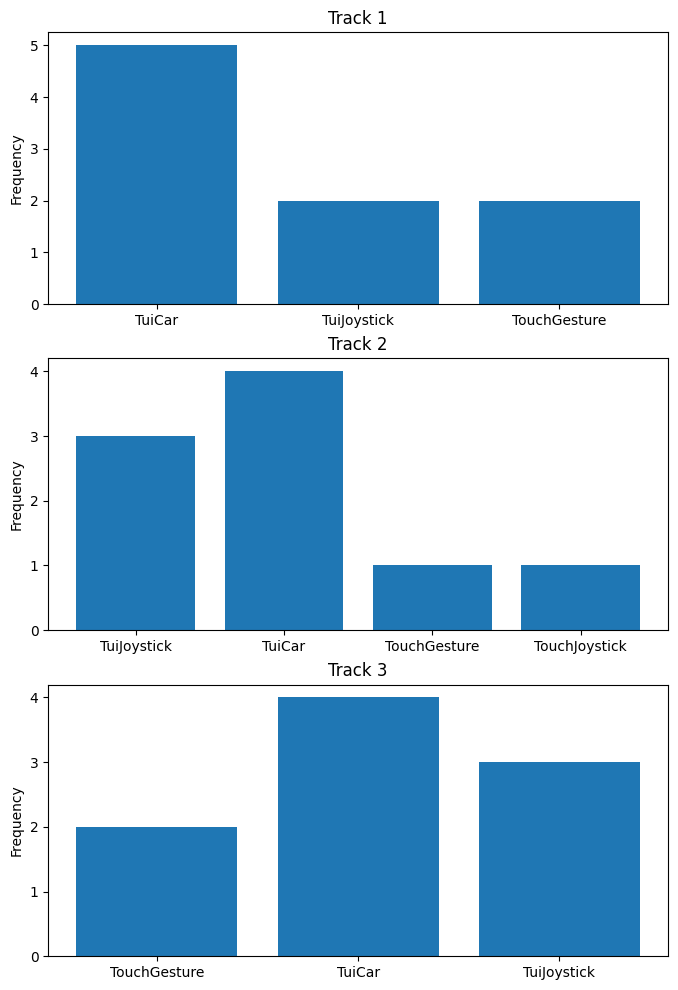

In [2]:
from matplotlib.ticker import MaxNLocator
from matplotlib import pyplot as plt, ticker
from collections import defaultdict
from typing import Dict, Tuple, List
import pandas as pd
from pandas import DataFrame
from pathlib import Path
from enum import StrEnum, Enum
from dataclasses import dataclass

class InputType(Enum):
    Touch = 1
    TUI = 2
    
class Metaphor(Enum):
    Gesture = 1
    Joystick = 2
    Car =  3
    
class InputCombination(Enum):
    TouchGesture = 1
    TouchJoystick = 2
    TuiJoystick = 3
    TuiCar = 4
    
    def __repr__(self):
        return self.name
    
    @staticmethod
    def build(input_type: InputType, metaphor: Metaphor):
        if input_type == InputType.Touch:
            if metaphor == Metaphor.Gesture:
                return InputCombination.TouchGesture
            if metaphor == Metaphor.Joystick:
                return InputCombination.TouchJoystick
        if input_type == InputType.TUI:
            if metaphor == Metaphor.Joystick:
                return InputCombination.TuiJoystick
            if metaphor == Metaphor.Car:
                return InputCombination.TuiCar

translation = {
    "Car" : "Car",
    "Auto" : "Car",
    "TUI" : "TUI",
    "Tangible" : "TUI",
    "Geste" : "Gesture",
    "Gesture" : "Gesture"
}


def parse_csv(path_to_csv: Path) -> DataFrame:
    with open(path_to_csv) as csv_file:
        return pd.read_csv(csv_file)

    
@dataclass
class UsabilityPerType:
    input_combination: InputCombination
    answers: Dict[str, str]
    
def parse_input_answer(answer: str) -> Tuple[InputCombination]:
    if answer == "Touch - Geste" or answer == "Touch - Gesten":
        return InputCombination.build(InputType.Touch, Metaphor.Gesture)
    elif answer == "Touch - Joystick":
        return InputCombination.build(InputType.Touch, Metaphor.Joystick)
    elif answer == "Tangible - Joystick":
        return InputCombination.build(InputType.TUI, Metaphor.Joystick)
    elif answer == "Tangible - Auto":
        return InputCombination.build(InputType.TUI, Metaphor.Car)
    
@dataclass
class Result:
    user_id: int
    age: int
    sequence: List[Tuple[InputCombination]]
    usage_frequency: Dict[str, str]
    usabilities: List[UsabilityPerType]
    fastest: Dict[str, Tuple[InputCombination]]
    most_accurate: Dict[str, Tuple[InputCombination]]
    ranking: List[InputCombination]
    
    def __init__(self, answers):
        self.questions_per_input = 8
        self.start_indices = {
            "TouchGesture" : 10,
            "TouchJoystick": 19,
            "TuiCar": 28,
            "TuiJoystick" : 37
        }
        self.user_id = answers.iloc[1]
        self.age = answers.iloc[2]
        self.sequence = self._get_sequence(answers)
        self.usage_frequency = self._get_usage_frequency(answers)
        self.usabilities = self._get_usabilities(answers)
        self.fastest = self._get_fastest(answers)
        self.most_accurate = self._get_most_accurate(answers)
        self.ranking = self._get_ranking(answers)
    
    def _get_sequence(self, answers):
        sequence = []
        next_input = answers.iloc[9]
        while next_input != "Fertig":
            parsed_answer = parse_input_answer(next_input)
            sequence.append(parsed_answer)
            next_index = self.start_indices[f"{parsed_answer.name}"] + self.questions_per_input
            next_input = answers.iloc[next_index]
        return sequence
    
    def _get_usage_frequency(self, answers) -> Dict[str, str]:
        return {"Smartphone": answers.iloc[3], "Tablet": answers.iloc[4], "Multitouch-Tisch": answers.iloc[5],
                  "Tangibles": answers.iloc[6], "Videospiele": answers.iloc[7]}
    
    def _get_usabilities(self, answers) -> List[UsabilityPerType]:
        usabilities = []
        for input_combination in InputCombination:
            key = f"{input_combination.name}"
            if key not in self.start_indices.keys():
                continue
            
            start_index = self.start_indices[key]
            _answers = {}
            for index in range(start_index, start_index + self.questions_per_input):
                question = answers.index[index]
                answer = answers[question]
                _answers[question.split("[")[0].strip()] = answer
            usabilities.append(UsabilityPerType(input_combination, _answers))
        return usabilities
    
    def _get_fastest(self, answers):
        result = {}
        for track, i in enumerate(range(46, 49)):
            result[f"Track {track+1}"] = parse_input_answer(answers.iloc[i])
        return result
    
    def _get_most_accurate(self, answers):
        result = {}
        for track, i in enumerate(range(49, 52)):
            result[f"Track {track + 1}"] = parse_input_answer(answers.iloc[i])
        return result
    
    def _get_ranking(self, answers):
        result = {}
        for rank, i in enumerate(range(52, 56)):
            result[f"Platz {rank + 1}"] = (parse_input_answer(answers.iloc[i]))
        return result
        
        
@dataclass
class ResultRepository:
    results: List[Result]
    def __init__(self):
        path_to_csv = Path('questionnaire_results/Fragebogen Masterarbeit.csv')
        self.data_frame: DataFrame  = parse_csv(path_to_csv)
        self.parse_data_frame(self.data_frame)
    
    def parse_data_frame(self, data_frame: DataFrame):
        self.results = [Result(data_frame.loc[index]) for index in data_frame.index]
        
    def get_by_user(self, user_id: int) -> Result:
        return [result for result in self.results if result.user_id == user_id][0]
    
    def get_all(self):
        return self.results


class RankCategory(Enum):
    Fastest = 1
    MostAccurate = 2
    Ranking = 3

class ResultPlotter:
    def __init__(self):
        self.repo = ResultRepository()
        self.results = self.repo.get_all()
        data = {
            'UserId': [result.user_id for result in self.results],
            'Age': [result.age for result in self.results],
            'Sequence': [result.sequence for result in self.results],
            RankCategory.Fastest.name : [result.fastest for result in self.results],
            RankCategory.MostAccurate.name: [result.most_accurate for result in self.results],
            RankCategory.Ranking.name: [result.ranking for result in self.results],
            'UsageFrequency': [result.usage_frequency for result in self.results],
        }
        self.data_frame = pd.DataFrame(data)
        
    def summary(self):
        return self.data_frame.style.format()
        
    def print_sequence(self):
        for result in self.results:
            print(f"UserId: {result.user_id} -> {result.sequence}")
    
    def plot_rankings(self, category: RankCategory):
        key_value_counts = defaultdict(lambda: defaultdict(int))
        for d in self.data_frame[category.name]:
            for key, value in d.items():
                key_value_counts[key][value] += 1
        
        num_keys = len(key_value_counts)    
        fig, axes = plt.subplots(nrows=num_keys, figsize=(8, 4 * num_keys))
        for ax, (key, value_counts) in zip(axes, key_value_counts.items()):
            ax.yaxis.set_major_locator(MaxNLocator(integer=True))
            x_values = [e.name for e in value_counts.keys()]
            y_values = list(value_counts.values())
            ax.bar(x_values, y_values)
            ax.set_title(f"{key}")
            ax.set_ylabel("Frequency")
        
        
            
plotter = ResultPlotter()
plotter.plot_rankings(RankCategory.MostAccurate)
plotter.summary()
# plotter.print_orders()
